# Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
%matplotlib inline
import lib.DB_lib as dl
import lib.Data_lib as dtl
import lib.VAE_lib as VAE
import lib.WGAN_lib as WGAN
from sklearn.decomposition import PCA
import torch
from joblib import dump, load
import Constants

# Constants

In [2]:
num_components = Constants.num_components
mills_for_1min = Constants.mills_for_1min
sample_rate_1h = Constants.sample_rate_1h
total_time_steps = Constants.test_total_time_steps
no_of_points = Constants.test_no_of_points
sliding_window_size = Constants.sliding_window_size
symbol = 'solusdt'
interval = Constants.interval

vae_model_path = '../VAE_model/vae_model_solusdt.pth'
min_max_scaler = '../scalar/min_max_scalar_solusdt.pkl'
standard_scaler = '../scalar/standard_scalar_solusdt.pkl'
wgan_x_scaler_path = '../trained_gan/wgan_x_scaler_solusdt.pkl'
wgan_y_scaler_path = '../trained_gan/wgan_y_scaler_solusdt.pkl'
wgan_model = '../trained_gan/modelG1.pth'

In [3]:
def sliding_window(x, window):
    x_ = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        x_.append(tmp_x)
    x_ = torch.from_numpy(np.array(x_)).float()
    return x_

# Data Import

In [4]:
data_frame = dl.get_dataset_for_time_period(symbol, interval, total_time_steps)
data_frame['closet_time'] = pd.to_datetime(data_frame['closet_time'], unit='ms')
data_frame

,start_time,closet_time,open,close,high,low,volume,no_of_trades,quote_taker_ast_vol,buy_base_ast_vol,taker_buy_quote_ast_vol
0,1715278500000,2024-05-09 18:29:59.999,147.22000000,147.18000000,147.31000000,146.95000000,16045.67400000,2877,2361376.44379000,7479.37400000,1100784.70217000
1,1715277600000,2024-05-09 18:14:59.999,146.61000000,147.23000000,147.27000000,146.44000000,15836.72000000,3565,2328642.90918000,9545.39000000,1403533.28421000
2,1715276700000,2024-05-09 17:59:59.999,147.20000000,146.62000000,147.47000000,146.49000000,20776.17500000,4557,3054540.10151000,10274.76500000,1510540.92965000
3,1715275800000,2024-05-09 17:44:59.999,147.06000000,147.20000000,147.30000000,146.70000000,13806.39900000,3482,2030681.05295000,7878.82800000,1158976.70985000
4,1715274900000,2024-05-09 17:29:59.999,146.45000000,147.06000000,147.18000000,146.25000000,24935.19200000,4935,3659384.81345000,14446.73600000,2120712.69832000
...,...,...,...,...,...,...,...,...,...,...,...
6995,1708983000000,2024-02-26 21:44:59.999,108.75000000,108.46000000,108.87000000,108.43000000,33134.61000000,4951,3600305.82300000,13224.69000000,1436886.88920000
6996,1708982100000,2024-02-26 21:29:59.999,109.01000000,108.75000000,109.04000000,108.65000000,26993.35000000,4672,2937826.94720000,11117.72000000,1210144.52630000
6997,1708981200000,2024-02-26 21:14:59.999,109.14000000,109.00000000,109.23000000,108.50000000,42911.91000000,9026,4668122.27310000,14176.87000000,1542550.80400000
6998,1708980300000,2024-02-26 20:59:59.999,109.11000000,109.14000000,109.19000000,108.88000000,37321.52000000,5183,4070366.47120000,15946.87000000,1739280.61020000


## Create upper level DataFrame

In [5]:
df_list = []
for k in range(sample_rate_1h):
    df = pd.DataFrame()
    for i in range(no_of_points):
        ending_point = i*sample_rate_1h+k
        starting_point = (i+1)*sample_rate_1h-1+k
        closet_time = data_frame.loc[ending_point, 'closet_time']
        open_price = data_frame.loc[starting_point, 'open'] 
        close_price = data_frame.loc[ending_point, 'close'] 
        high_price = data_frame.loc[ending_point:starting_point, 'high'].max()
        low_price = data_frame.loc[ending_point:starting_point, 'low'].max()
        volume = data_frame.loc[ending_point:starting_point, 'volume'].sum()
        no_of_trades = data_frame.loc[ending_point:starting_point, 'no_of_trades'].sum()
        quote_taker_ast_vol = data_frame.loc[ending_point:starting_point, 'quote_taker_ast_vol'].sum()
        buy_base_ast_vol = data_frame.loc[ending_point:starting_point, 'buy_base_ast_vol'].sum()
        taker_buy_quote_ast_vol = data_frame.loc[ending_point:starting_point, 'taker_buy_quote_ast_vol'].sum()
        df = df._append({'closet_time': closet_time, 
                        'open': open_price, 
                        'close': close_price, 
                        'high': high_price, 
                        'low': low_price, 
                        'volume': volume, 
                        'no_of_trades': no_of_trades, 
                        'quote_taker_ast_vol': quote_taker_ast_vol, 
                        'buy_base_ast_vol': buy_base_ast_vol, 
                        'taker_buy_quote_ast_vol': taker_buy_quote_ast_vol}, ignore_index=True)
    df_list.append(df)   

for i in range(len(df_list)):
    print(df_list[i]['closet_time'])

time_range = df_list[0]['closet_time'][0]   
last_price = df_list[0]['close'][0]

0     2024-05-09 18:29:59.999
1     2024-05-09 14:29:59.999
2     2024-05-09 10:29:59.999
3     2024-05-09 06:29:59.999
4     2024-05-09 02:29:59.999
                ...          
395   2024-03-04 22:29:59.999
396   2024-03-04 18:29:59.999
397   2024-03-04 14:29:59.999
398   2024-03-04 10:29:59.999
399   2024-03-04 06:29:59.999
Name: closet_time, Length: 400, dtype: datetime64[ns]
0     2024-05-09 18:14:59.999
1     2024-05-09 14:14:59.999
2     2024-05-09 10:14:59.999
3     2024-05-09 06:14:59.999
4     2024-05-09 02:14:59.999
                ...          
395   2024-03-04 22:14:59.999
396   2024-03-04 18:14:59.999
397   2024-03-04 14:14:59.999
398   2024-03-04 10:14:59.999
399   2024-03-04 06:14:59.999
Name: closet_time, Length: 400, dtype: datetime64[ns]
0     2024-05-09 17:59:59.999
1     2024-05-09 13:59:59.999
2     2024-05-09 09:59:59.999
3     2024-05-09 05:59:59.999
4     2024-05-09 01:59:59.999
                ...          
395   2024-03-04 21:59:59.999
396   2024-03-04 17:59

# Data Visualization & Preprocess

In [6]:
last_price = df_list[0]['close'][0]

In [7]:
use_cuda = 0
device = "cpu"
output = []
for i in range(len(df_list)):
    dataset_ex_df = df_list[i]
    dataset_ex_df = dataset_ex_df.iloc[::-1]
    dataset_ex_df.reset_index(drop=True, inplace=True)
    #--------------------------------------------------------------------------------------------------------
    dataset_ex_df['pct_change'] = (dataset_ex_df['close'] - dataset_ex_df['close'].shift(1))/ dataset_ex_df['close'].shift(1)
    dataset_ex_df['log_change'] = np.log((dataset_ex_df['close']/ dataset_ex_df['close'].shift(1)).astype(float))
    dataset_ex_df['prev_close'] = dataset_ex_df['close'].shift(2)
    dataset_ex_df = dataset_ex_df.dropna()
    #-------------------------------------------------------------------------------------------------------
    dataset_Idc = dtl.CreateInc(dataset_ex_df,"close","high","low","volume")
    #--------------------------------------------------------------------------------------------------------
    close_fft = np.fft.fft(np.asarray(dataset_Idc['close'].tolist()))
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    output_df_fft = fft_df.copy()
    
    fft_list = np.asarray(fft_df['fft'].tolist())
    for num_ in [3, 6, 9, 27, 81, 100]:
        fft_list_m10= np.copy(fft_list) 
        fft_list_m10[num_:-num_]=0
        output_df_fft[f'FT_{num_}components'] = np.fft.ifft(fft_list_m10).astype('float')
        
    df_idc_fft = pd.concat([dataset_Idc,output_df_fft[["FT_3components","FT_6components","FT_9components","FT_27components","FT_81components","FT_100components"]]], axis=1)
    
    #--------------------------------------------------------------------------------------------------
    # data = df_idc_fft.iloc[:,1:]
    # data.drop('close', axis=1, inplace=True)
    # features = data.shape[1]
    # x = data.values
    # x_scaler = load(min_max_scaler)
    # train_x = x_scaler.fit_transform(x)
    # model = VAE.VAE([features, 400, 400, 400, 10], 10)
    # model.load_state_dict(torch.load(vae_model_path))
    # model.eval()
    # _, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
    # df_tr = pd.DataFrame(VAE_train_x.cpu().detach().numpy(), columns=['enc1', 'enc2', 'enc3', 'enc4', 'enc5', 'enc6', 'enc7', 'enc8', 'enc9', 'enc10'])
    # df_idc_fft_vae = pd.concat([df_idc_fft, df_tr], axis=1)
    # df_idc_fft = df_idc_fft_vae
    #-------------------------------------------------------------------------------------------------------------------
    
    
    df_pca=df_idc_fft.drop(['closet_time'], axis=1)
    X = df_pca.values # matrix of dataframe 
    sc = load(standard_scaler)
    X_std = sc.fit_transform(X) # standardizing the data
    pca = PCA(num_components)  
    X_pca = pca.fit_transform(X_std)
    df_PCA=X_pca.copy()
    df_PCA = pd.DataFrame(df_PCA,columns=["pca1","pca2","pca3","pca4","pca5","pca6","pca7","pca8","pca9","pca10","pca11","pca12","pca13","pca14","pca15","pca16","pca17"])
    
    #-----------------------------------------------------------------------------------------------------------------------

    output.append(df_PCA)

C:\Users\KAVISHKA\AppData\Local\Temp\ipykernel_34736\1734348001.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_ex_df['pct_change'] = (dataset_ex_df['close'] - dataset_ex_df['close'].shift(1))/ dataset_ex_df['close'].shift(1)
C:\Users\KAVISHKA\AppData\Local\Temp\ipykernel_34736\1734348001.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_ex_df['log_change'] = np.log((dataset_ex_df['close']/ dataset_ex_df['close'].shift(1)).astype(float))
C:\Users\KAVISHKA\AppData\Local\Temp\ipykernel_

#### Initial Shape of the BTC Dataset

In [8]:
output[0].tail(11)

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17
100,-3.491556,-0.938952,-0.806302,-1.740851,-1.464097,0.649575,0.224144,0.176348,0.594664,0.263772,0.034397,-0.300110,-0.268949,0.188414,-0.094048,0.303675,-0.065653
101,-2.465324,-1.761513,0.045052,-2.615157,-1.214100,0.818905,0.238804,0.169863,0.540569,0.164356,-0.046825,-0.463215,0.223231,0.087154,-0.307884,0.146054,0.026741
102,-2.442178,-1.224134,0.158828,-1.004207,-1.681666,1.392804,0.636427,0.384848,0.614415,0.107180,-0.088275,-0.182625,-0.155011,0.176887,-0.317161,0.078317,-0.150718
103,-2.429832,-1.059809,-0.599611,-0.320846,-2.160538,1.528650,0.641931,0.383725,0.295495,0.264632,0.244581,-0.103354,-0.195965,0.066956,-0.178130,0.202939,0.032368
104,-2.519279,-1.174276,-0.671022,-0.583399,-2.170572,1.334464,0.729555,0.359256,-0.087788,0.305986,0.406562,-0.078814,-0.371121,0.011702,0.057461,0.152887,0.094895
105,-0.837788,-2.969770,2.040371,-4.431259,0.067848,1.195974,1.013183,-0.119806,-0.198804,0.189480,-0.148007,-0.186307,0.361106,-0.229183,-0.121398,-0.232588,-0.077429
106,-0.991733,-1.721373,-1.591612,0.277009,-2.430306,2.187252,0.543484,0.498660,0.352761,0.146594,-0.104586,-0.215216,0.083429,0.131457,0.478132,-0.087629,-0.096560
107,-0.981966,-1.601523,-1.198671,-0.149607,-2.163581,1.694834,0.963811,0.167821,-0.206170,0.159992,-0.016199,0.151634,0.204206,-0.258841,-0.170771,-0.125912,0.136062
108,-0.229269,-2.581211,-1.415933,-2.304176,-0.770515,1.570241,1.132192,-0.166648,-0.377274,0.253552,-0.367406,0.309091,0.187828,-0.291979,0.093162,-0.096894,-0.049932
109,-0.512882,-1.518641,-0.820379,0.488227,-2.515033,1.643924,1.000575,0.184420,-0.238589,0.067978,-0.693879,0.292899,-0.023180,-0.137286,0.407243,-0.012186,0.026646


In [9]:
wgan_x_scaler = load(wgan_x_scaler_path)
wgan_y_scaler = load(wgan_y_scaler_path)
modelG2 = WGAN.Generator(output[0].shape[1])
modelG2.load_state_dict(torch.load(wgan_model,map_location=torch.device('cpu')))
# modelG2.eval()

final = []
for i in range(len(output)):
    test_x = output[i].tail(11)
    test_x = wgan_x_scaler.transform(test_x)
    test_x_slide = sliding_window(test_x, sliding_window_size)
    pred_y_train, gru_output = modelG2(test_x_slide)
    y_test_pred  = wgan_y_scaler.inverse_transform(pred_y_train.detach().numpy())
    final.append(y_test_pred[0][0])

In [10]:
final

[47.884212,
 51.707317,
 60.743267,
 54.35884,
 52.493683,
 50.94107,
 55.489803,
 50.499874,
 52.607784,
 58.778473,
 44.69198,
 43.97452,
 49.67872,
 50.58403,
 48.72132,
 47.069088]

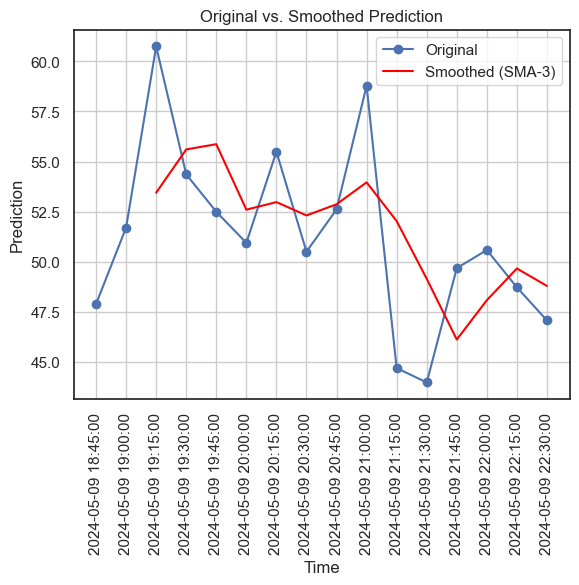

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# Given start time and interval
start_time = pd.Timestamp(time_range + timedelta(minutes=15,milliseconds=1))
interval_minutes = 15

# Generate time values for the x-axis
time_values = [start_time + timedelta(minutes=i*interval_minutes) for i in range(len(final))]

# Apply simple moving average (SMA) with window size 3
window_size = 3
smoothed_values = np.convolve(final, np.ones(window_size)/window_size, mode='valid')

# Plot original and smoothed prediction values
plt.plot(time_values, final, label='Original', marker='o')
plt.plot(time_values[window_size-1:], smoothed_values, label=f'Smoothed (SMA-{window_size})', color='red')
plt.xlabel('Time')
plt.ylabel('Prediction')
plt.title('Original vs. Smoothed Prediction')
plt.xticks(time_values, [time.strftime('%Y-%m-%d %H:%M:%S') for time in time_values], rotation=90)  # Specify time values with custom formatting
plt.legend()
plt.grid(True)
plt.show()